## New Review Graphs

Compute range (should be large, e.g., ~1e14 → 1e17+): 1.68e+17 → 1.34e+22


'Figures/time_alg_progress.png'

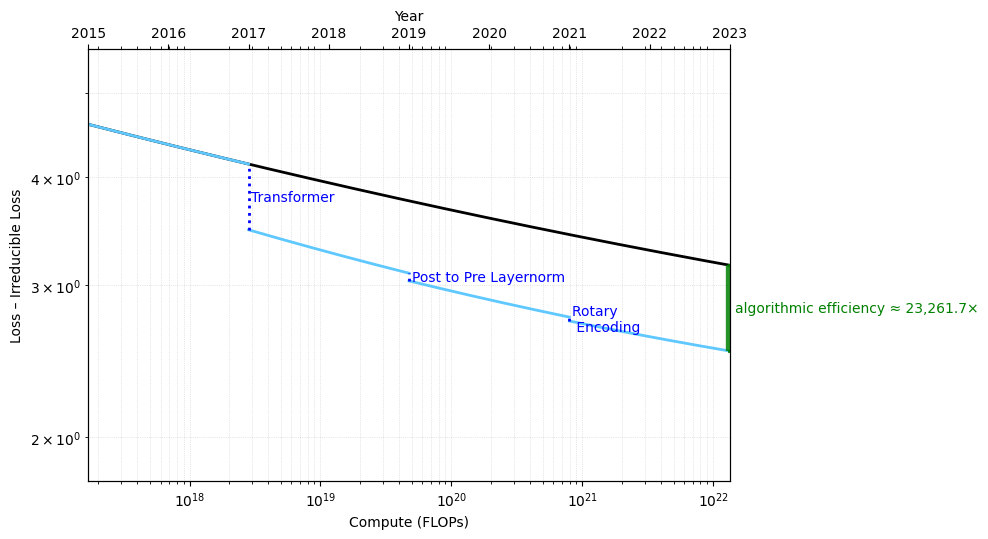

In [9]:
# Minimal, self-contained plotting cell with safety checks
import numpy as np
import matplotlib.pyplot as plt

# ---------- EDITABLE PARAMETERS ----------
# Year→Compute mapping: C(year) = C0 * exp(k * (year - y0))
y0 = 2013
C0 = 1e16                 # compute at reference year (use large value, e.g., 1e14)
k  = np.log(4.1) / 1.0      # NATURAL log: 4.1x evey 1.0 year

# Baseline power law L = A0 * C^(-alpha0) + E
A0, alpha0, E = 35.5, 0.064, 1.8

# Disjoint algorithmic segments: (start_year, end_year, A, alpha)
segments = [
    (2015, 2017, 35.5, 0.064),
    (2017, 2019.0, 80, 0.091),
    (2019, 2021, 80*(1.73**-0.091), 0.091),
    (2021, 2023, 80*((1.27*1.1*1.73)**-0.091), 0.091),
]
# Labels for transitions between segments (len = len(segments) - 1)
transition_labels = ["Transformer", "Post to Pre Layernorm", "Rotary \n Encoding"]

# Year window
plot_year_start, plot_year_end = 2015.0, 2023.0

# Appearance
segment_color = "#5ec8ff"   # light blue for all segments
transition_color = "blue"
baseline_color = "black"
efficiency_color = "green"

# --------- Y-axis limits (log-scale) ---------
# You can set these values to focus on your region of interest:
# e.g. ymin = 2, ymax = 40
ylim_lower = 10**0.25  # SET THIS VALUE as desired
ylim_upper = 10**0.75 # SET THIS VALUE as desired
# ---------------------------------------------

# Mapping + helpers
def year_to_compute(year):
    return C0 * np.exp(k * (year - y0))

def loss(A, alpha, C):
    return A * (C ** (-alpha)) + E

def loss_at_year_from_segments(year):
    chosen = None
    for (ys, ye, A, alpha) in segments:
        if ys <= year <= ye:
            chosen = (A, alpha)
            break
        if ye < year:
            chosen = (A, alpha)
    if chosen is None:
        return loss(A0, alpha0, year_to_compute(year))
    A_sel, alpha_sel = chosen
    return loss(A_sel, alpha_sel, year_to_compute(year))

# Safety check: compute range
compute_min = year_to_compute(plot_year_start)
compute_max = year_to_compute(plot_year_end)
print("Compute range (should be large, e.g., ~1e14 → 1e17+):",
      f"{compute_min:.2e} → {compute_max:.2e}")

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 5.5))

# Axes on log scales
ax.set_xscale('log')
ax.set_yscale('log')

# Force x-limits to the compute range (prevents autoscaling to ~[1,10])
ax.set_xlim(compute_min, compute_max)

# ---- Set y-limits to chosen region (log scale safe) ----
ax.set_ylim(ylim_lower, ylim_upper)

# Labels
ax.set_xlabel("Compute (FLOPs)")
ax.set_ylabel("Loss – Irreducible Loss")

# Baseline curve
C_grid = np.logspace(np.log10(compute_min), np.log10(compute_max), 1200)
ax.plot(C_grid, loss(A0, alpha0, C_grid), color=baseline_color, linewidth=2)

# Algorithmic segments (uniform color)
for (ys, ye, A, alpha) in segments:
    ys_c, ye_c = max(ys, plot_year_start), min(ye, plot_year_end)
    if ye_c <= ys_c:
        continue
    years = np.linspace(ys_c, ye_c, 200)
    C_seg = year_to_compute(years)
    L_seg = loss(A, alpha, C_seg)
    ax.plot(C_seg, L_seg, color=segment_color, linewidth=2)

# Transition lines + labels
for i in range(len(segments) - 1):
    _, ye, A1, a1 = segments[i]
    ys2, _, A2, a2 = segments[i + 1]
    t = ye
    C_t = year_to_compute(t)
    L1 = loss(A1, a1, C_t)
    L2 = loss(A2, a2, C_t)
    # vertical dotted line at transition
    ax.plot([C_t, C_t], [min(L1, L2), max(L1, L2)],
            linestyle=":", linewidth=2, color=transition_color)
    # label at geometric mean height
    y_mid = (L1 * L2) ** 0.5
    label = transition_labels[i] if i < len(transition_labels) else f"Δ{i+1}"
    ax.text(C_t * 1.05, y_mid, label, color=transition_color, va='center')

# Green vertical efficiency line at the final compute position
final_year = min(plot_year_end, segments[-1][1])
C_final = year_to_compute(final_year)
L_algo_final = loss_at_year_from_segments(final_year)
L_base_final = loss(A0, alpha0, C_final)
ax.vlines(C_final, ymin=L_algo_final, ymax=L_base_final,
          color=efficiency_color, linewidth=6, alpha=0.85)
# little ticks at ends
ax.plot([C_final * 0.98, C_final * 1.02], [L_base_final, L_base_final],
        color=efficiency_color, linewidth=2)
ax.plot([C_final * 0.98, C_final * 1.02], [L_algo_final, L_algo_final],
        color=efficiency_color, linewidth=2)

# Efficiency label (compact format if huge)
if L_algo_final > E:
    C_equiv = ((L_algo_final - E) / A0) ** (-1 / alpha0)  # baseline compute needed to match algo loss
    eff_mult = C_equiv / C_final
    eff_text = f"algorithmic efficiency ≈ {eff_mult:.1e}×" if eff_mult > 1e6 else f"algorithmic efficiency ≈ {eff_mult:,.1f}×"
else:
    eff_text = "algorithmic efficiency"
ax.text(C_final * 1.10, (L_algo_final * L_base_final) ** 0.5, eff_text,
        color=efficiency_color, va='center')

# Top axis: years mapped to the same log x
ax_top = ax.twiny()
ax_top.set_xscale('log')
ax_top.set_xlim(ax.get_xlim())
years = np.arange(int(np.floor(plot_year_start)), int(np.ceil(plot_year_end)) + 1)
tick_positions = year_to_compute(years)
mask = (tick_positions >= compute_min) & (tick_positions <= compute_max)
ax_top.set_xticks(tick_positions[mask])
ax_top.set_xticklabels([str(y) for y in years[mask]])
ax_top.set_xlabel("Year")

# Styling
ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.6)
plt.tight_layout()

out_path = "Figures/time_alg_progress.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
out_path


Compute range (should be large, e.g., ~1e14 → 1e17+): 1.68e+17 → 1.34e+22


'Figures/time_alg_progress.png'

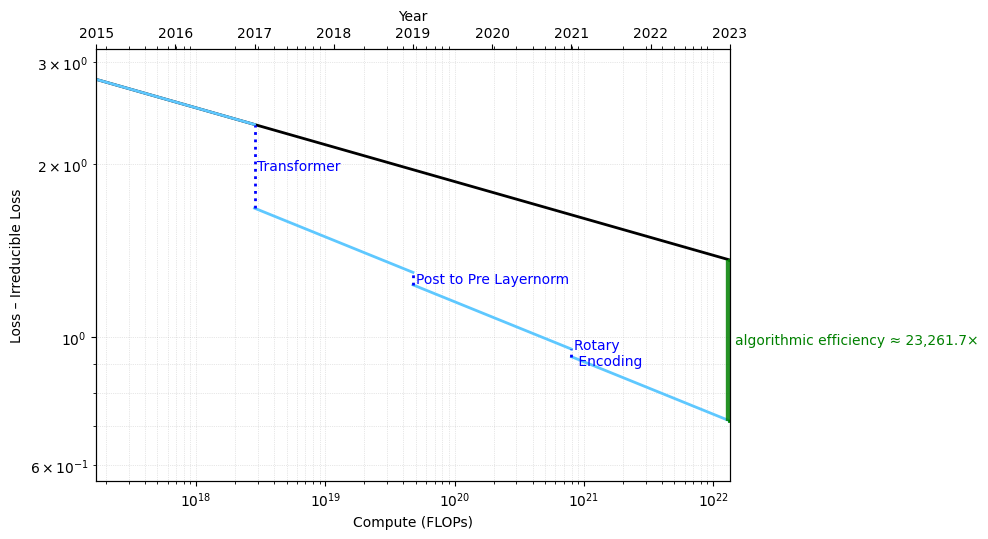

'Figures/algorithmic_progress_powerlaw.png'

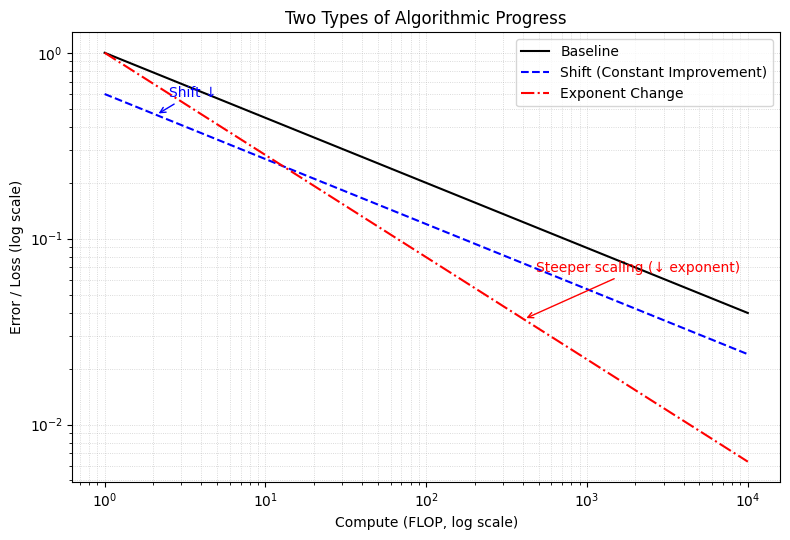

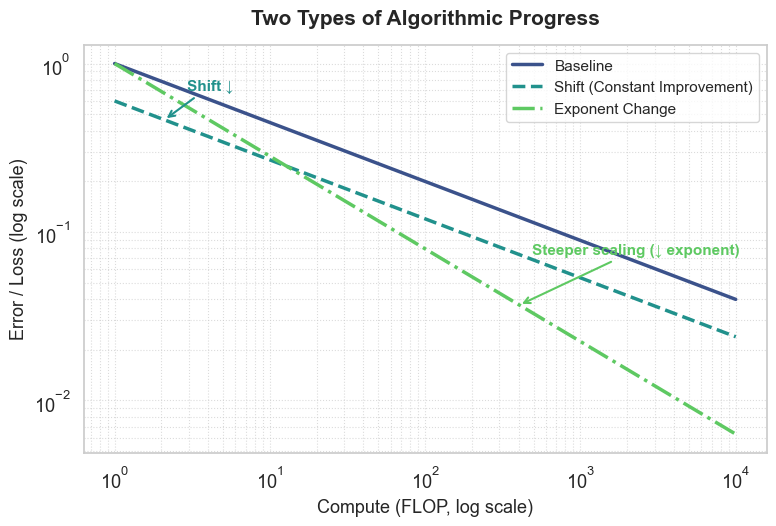

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply Seaborn style
sns.set(style="whitegrid", palette="viridis", font_scale=1.2)

# ---------------- USER-EDITABLE PARAMETERS ----------------
# Baseline curve: A * C^(-alpha)
A0   = 1.0
alpha0 = 0.35

# "Shift" (constant improvement): multiply A by a factor < 1 (vertical drop across all compute)
shift_factor = 0.6  # e.g., 0.6 means 40% improvement at all compute

# "Steeper scaling": change the exponent (larger alpha => steeper improvement with compute)
alpha_steeper = 0.55

# X-axis (compute, in FLOP)
C_min, C_max = 1e0, 1e4
num_points = 400
# ---------------------------------------------------------

def power_law(C, A, alpha):
    return A * C**(-alpha)

C = np.logspace(np.log10(C_min), np.log10(C_max), num_points)

# Curves
baseline = power_law(C, A0, alpha0)
shift_curve = power_law(C, A0 * shift_factor, alpha0)
steeper_curve = power_law(C, A0, alpha_steeper)

# Plot
fig, ax = plt.subplots(figsize=(8, 5.5))

ax.loglog(C, baseline, color=sns.color_palette("viridis", 3)[0], linewidth=2.5, label="Baseline")
ax.loglog(C, shift_curve, linestyle="--", color=sns.color_palette("viridis", 3)[1], linewidth=2.5, label="Shift (Constant Improvement)")
ax.loglog(C, steeper_curve, linestyle="dashdot", color=sns.color_palette("viridis", 3)[2], linewidth=2.5, label="Exponent Change")

# Labels & Title
ax.set_title("Two Types of Algorithmic Progress", fontsize=15, weight="bold", pad=15)
ax.set_xlabel("Compute (FLOP, log scale)", fontsize=13)
ax.set_ylabel("Error / Loss (log scale)", fontsize=13)

# Grid
ax.grid(which="both", linestyle=":", linewidth=0.8, alpha=0.7)

# Annotations
x_shift = C[int(len(C)*0.08)]
y_shift = power_law(x_shift, A0 * shift_factor, alpha0)
ax.annotate("Shift ↓",
            xy=(x_shift, y_shift),
            xytext=(x_shift*1.4, y_shift*1.5),
            arrowprops=dict(arrowstyle="->", lw=1.5, color=sns.color_palette("viridis", 3)[1]),
            fontsize=11, color=sns.color_palette("viridis", 3)[1], weight="bold")

x_step = C[int(len(C)*0.65)]
y_steeper = power_law(x_step, A0, alpha_steeper)
ax.annotate("Steeper scaling (↓ exponent)",
            xy=(x_step, y_steeper),
            xytext=(x_step*1.2, y_steeper*2),
            arrowprops=dict(arrowstyle="->", lw=1.5, color=sns.color_palette("viridis", 3)[2]),
            fontsize=11, color=sns.color_palette("viridis", 3)[2], weight="bold")

# Legend
ax.legend(loc="upper right", frameon=True, fontsize=11)

plt.tight_layout()

# Save to file
# out_path = "/mnt/data/algorithmic_progress_seaborn.png"
# plt.savefig(out_path, dpi=250, bbox_inches="tight")
# out_path


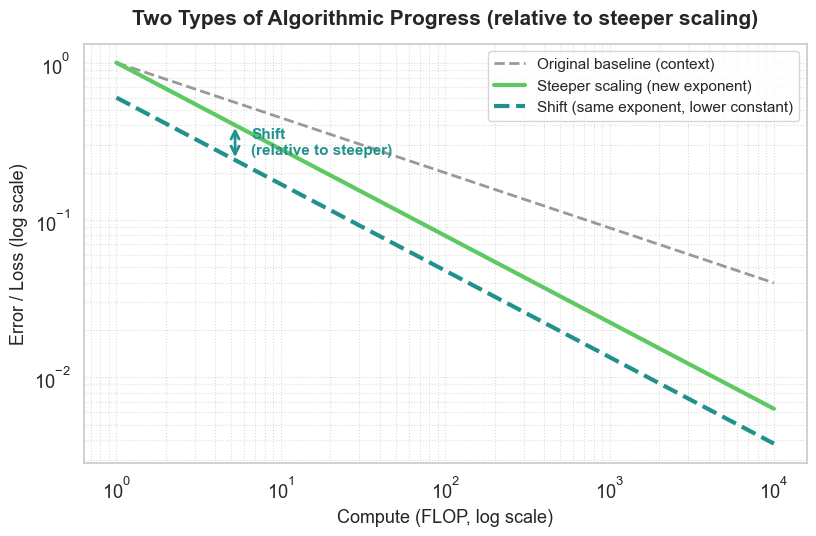

'Figures/algorithmic_progress_types.png'

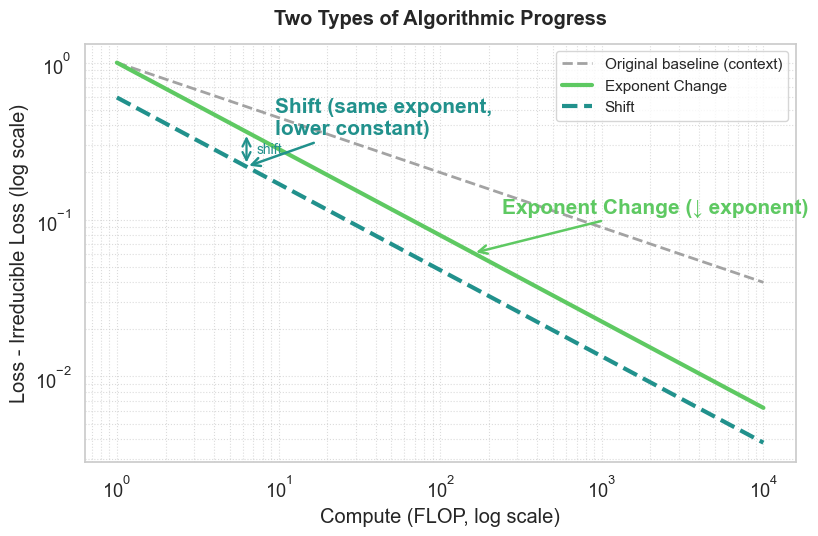

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Style
sns.set(style="whitegrid", palette="viridis", font_scale=1.2)

# ---------------- USER-EDITABLE PARAMETERS ----------------
# Context/original baseline
A0, alpha0 = 1.0, 0.35

# Steeper scaling (new exponent) — SOLID reference
A1, alpha1 = 1.0, 0.55

# Shift relative to the steeper scaling (same exponent, lower constant)
shift_factor = 0.6
# ---------------------------------------------------------

def power_law(C, A, alpha):
    return A * C**(-alpha)

# Domain
C = np.logspace(0, 4, 400)

# Curves
ctx = power_law(C, A0, alpha0)                     # gray dashed (context)
steeper = power_law(C, A1, alpha1)                 # solid (reference)
shifted = power_law(C, A1 * shift_factor, alpha1)  # dashed (same slope)

# Colors
pal = sns.color_palette("viridis", 3)
col_ctx = "0.6"
col_steeper = pal[2]
col_shift = pal[1]

# Plot
fig, ax = plt.subplots(figsize=(8.6, 5.6))

ax.loglog(C, ctx, "--", lw=2, color=col_ctx, alpha=0.9, label="Original baseline (context)")
ax.loglog(C, steeper, "-", lw=3, color=col_steeper, label="Exponent Change")
ax.loglog(C, shifted, "--", lw=3, color=col_shift, label="Shift")

# Title / labels
ax.set_title("Two Types of Algorithmic Progress", weight="bold", pad=14)
ax.set_xlabel("Compute (FLOP, log scale)")
ax.set_ylabel("Loss - Irreducible Loss (log scale)")

ax.grid(which="both", linestyle=":", linewidth=0.8, alpha=0.7)

# ---------- Clear, unambiguous arrow labels ----------
# Arrow to STEEPER line with text "Exponent Change"
x_s = C[int(len(C)*0.55)]
y_s = power_law(x_s, A1, alpha1)
ax.annotate("Exponent Change (↓ exponent)",
            xy=(x_s, y_s),
            xytext=(x_s*1.5, y_s*1.8),
            fontsize=15, color=col_steeper, weight="bold",
            arrowprops=dict(arrowstyle="->", lw=1.8, color=col_steeper))

# Arrow to SHIFTED line with text "Shift"
x_sh = C[int(len(C)*0.20)]
y_sh = power_law(x_sh, A1 * shift_factor, alpha1)
ax.annotate("Shift (same exponent,\nlower constant)",
            xy=(x_sh, y_sh),
            xytext=(x_sh*1.5, y_sh*1.6),
            fontsize=15, color=col_shift, weight="bold",
            arrowprops=dict(arrowstyle="->", lw=1.8, color=col_shift))

# Also show a small vertical bracket to visualize shift magnitude at one x
ax.annotate("", xy=(x_sh, y_sh), xytext=(x_sh, power_law(x_sh, A1, alpha1)),
            arrowprops=dict(arrowstyle="<->", lw=1.6, color=col_shift, shrinkA=3, shrinkB=3))
ax.text(x_sh*1.15, np.sqrt(y_sh*power_law(x_sh, A1, alpha1)), "shift", va="center",
        fontsize=10, color=col_shift)

ax.legend(loc="upper right", frameon=True, fontsize=11)

plt.tight_layout()

out_path = "Figures/algorithmic_progress_types.png"
plt.savefig(out_path, dpi=250, bbox_inches="tight")
out_path
